In [11]:
import pandas as pd

data = pd.read_csv("adult_income_dataset.csv")

variables = pd.get_dummies(data.drop([data.columns[-1]], axis=1))
target = data['income'].apply(lambda x: x == '>50K')

variables

,age,fnlwgt,educational-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,25,226802,7,0,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,38,89814,9,0,0,50,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2,28,336951,12,0,0,40,False,False,True,False,...,False,False,False,False,False,False,False,True,False,False
3,44,160323,10,7688,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,18,103497,10,0,0,30,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48837,27,257302,12,0,0,38,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
48838,40,154374,9,0,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
48839,58,151910,9,0,0,40,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
48840,22,201490,9,0,0,20,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [12]:
target.value_counts()

income
False    37155
True     11687
Name: count, dtype: int64

In [38]:
from sklearn.model_selection import train_test_split

v_train, v_test, t_train, t_test = train_test_split(variables, target, random_state=69, test_size=0.2)

import dalex as dx
import xgboost
import warnings
warnings.filterwarnings("ignore")

def use_model(model):
    model.fit(v_train, t_train)
    explainer = dx.Explainer(model, v_test, t_test, label=type(model).__name__)
    return explainer

def show_fairness(explainer):
    res = explainer.model_fairness(protected=v_test.age.apply(lambda x: "<=30" if x <= 30 else ">30"), privileged=">30")
    res.fairness_check()
    res.plot()

# Gradient boosting

In [32]:
from sklearn.ensemble import GradientBoostingClassifier

boosting = GradientBoostingClassifier()

bex = use_model(boosting)
bex.model_performance()

Preparation of a new explainer is initiated

  -> data              : 9769 rows 108 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 9769 values
  -> model_class       : sklearn.ensemble._gb.GradientBoostingClassifier (default)
  -> label             : GradientBoostingClassifier
  -> predict function  : <function yhat_proba_default at 0x000001890611C400> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.00289, mean = 0.238, max = 0.987
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.941, mean = 0.00179, max = 0.993
  -> model_info        : package sklearn

A new explainer has been created!


,recall,precision,f1,accuracy,auc
GradientBoostingClassifier,0.60333,0.80102,0.688261,0.868973,0.92212


Bias detected in 3 metrics: TPR, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on '>30'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
           TPR       ACC       PPV   FPR       STP
<=30  0.653291  1.154776  1.048811  0.08  0.130952


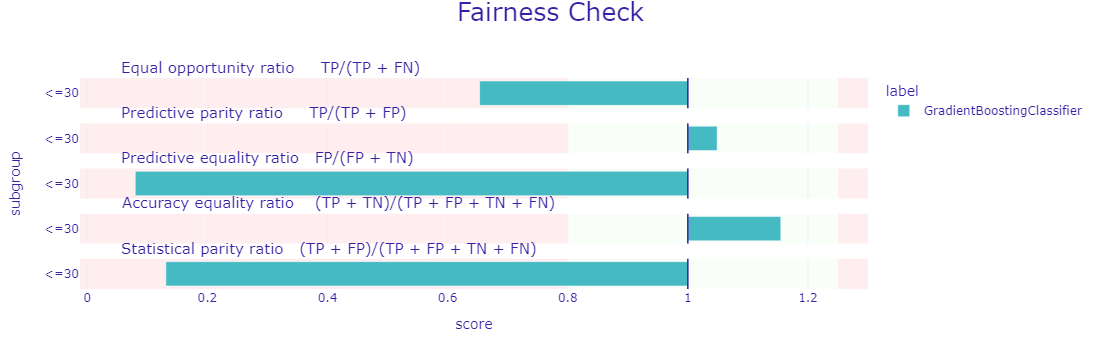

In [39]:
show_fairness(bex)

## Random Forest

In [40]:
from sklearn.ensemble import RandomForestClassifier

randomForest = RandomForestClassifier()
rex = use_model(randomForest)
rex.model_performance()

Preparation of a new explainer is initiated

  -> data              : 9769 rows 108 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 9769 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : RandomForestClassifier
  -> predict function  : <function yhat_proba_default at 0x000001890611C400> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.238, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = 0.00171, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


,recall,precision,f1,accuracy,auc
RandomForestClassifier,0.621691,0.728729,0.670968,0.853823,0.902211


Bias detected in 3 metrics: TPR, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on '>30'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
           TPR     ACC       PPV       FPR      STP
<=30  0.740973  1.1772  0.935792  0.144144  0.16726


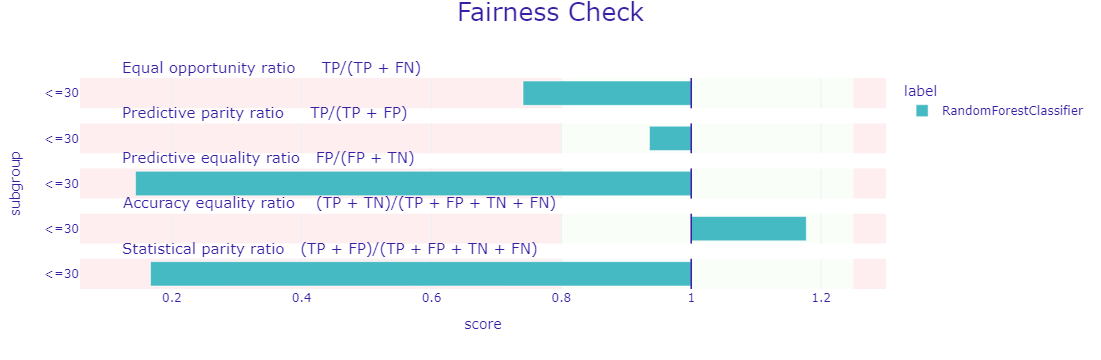

In [41]:
show_fairness(rex)

## Bias mitigation

In [43]:
from dalex.fairness import resample, reweight, roc_pivot
from copy import copy

randomForestResampled = copy(randomForest)

protected_train = v_train.age.apply(lambda x: "<=30" if x <= 30 else ">30")
indices_uniform = resample(protected_train, t_train, type='preferential', probs=randomForest.predict_proba(v_train)[:, 1], verbose=False)
randomForestResampled.fit(v_train.iloc[indices_uniform, :], t_train.iloc[indices_uniform])
explainer = dx.Explainer(randomForestResampled, v_test, t_test, label='RandomForestClassifier resampled')
explainer.model_performance()

Preparation of a new explainer is initiated

  -> data              : 9769 rows 108 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 9769 values
  -> model_class       : sklearn.ensemble._forest.RandomForestClassifier (default)
  -> label             : RandomForestClassifier resampled
  -> predict function  : <function yhat_proba_default at 0x000001890611C400> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.21, max = 1.0
  -> model type        : classification will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = 0.0301, max = 1.0
  -> model_info        : package sklearn

A new explainer has been created!


,recall,precision,f1,accuracy,auc
RandomForestClassifier resampled,0.563194,0.695675,0.622463,0.836217,0.87102


Bias detected in 4 metrics: TPR, PPV, FPR, STP

Conclusion: your model is not fair because 2 or more criteria exceeded acceptable limits set by epsilon.

Ratios of metrics, based on '>30'. Parameter 'epsilon' was set to 0.8 and therefore metrics should be within (0.8, 1.25)
           TPR       ACC       PPV       FPR       STP
<=30  1.378676  1.094945  0.430161  1.645161  0.665138


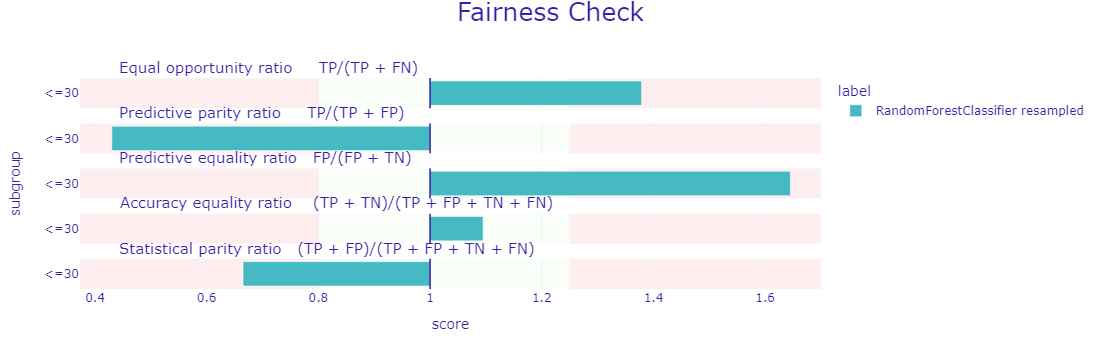

In [44]:
show_fairness(explainer)